In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_recall_fscore_support, roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12  
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12

In [7]:
df = pd.read_csv('D://My projects/customer_segmentation_project/data/processed/step6_evaluated_clusters.csv')
print(f"✓ Loaded data: {df.shape}")

n_clusters = len(df['Final_ML_Cluster'].unique())
print(f"✓ Number of clusters: {n_clusters}")

✓ Loaded data: (2229, 75)
✓ Number of clusters: 2


In [9]:
features_for_modeling = [
    'R_Score', 'F_Score', 'M_Score',
    'Age', 'Income', 'Education_Level', 'Family_Size', 'Has_Children',
    'Avg_Order_Value', 'Purchase_Frequency_Rate', 'Customer_Tenure_Days',
    'Wine_Ratio', 'Meat_Ratio', 'Product_Diversity', 'Premium_Product_Ratio',
    'Web_Purchase_Ratio', 'Store_Purchase_Ratio',
    'Campaign_Acceptance_Rate', 'NumWebVisitsMonth', 'Has_Complained', 'Engagement_Score',
    'CLV_Estimate', 'Customer_Value_Score',
    'Is_High_Spender', 'Is_Active', 'Is_Campaign_Responder', 
    'Is_Web_Shopper', 'Is_Deal_Seeker'
]

# Filter to available features
available_features = [f for f in features_for_modeling if f in df.columns]
print(f"✓ Using {len(available_features)} features for modeling")

X = df[available_features].values
y = df['Final_ML_Cluster'].values

print(f"✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")


✓ Using 28 features for modeling
✓ Features shape: (2229, 28)
✓ Target shape: (2229,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")

# Check class distribution
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

print("\nClass distribution:")
print("-" * 70)
for i in range(n_clusters):
    print(f"Cluster {i}: Train={train_dist[i]:4d} ({train_dist[i]/len(y_train)*100:5.1f}%), "
          f"Test={test_dist[i]:4d} ({test_dist[i]/len(y_test)*100:5.1f}%)")


✓ Training set: 1783 samples
✓ Test set: 446 samples

Class distribution:
----------------------------------------------------------------------
Cluster 0: Train=1261 ( 70.7%), Test= 315 ( 70.6%)
Cluster 1: Train= 522 ( 29.3%), Test= 131 ( 29.4%)


In [11]:
# BASELINE MODEL - LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f"✓ Logistic Regression Accuracy: {lr_accuracy:.4f}")

✓ Logistic Regression Accuracy: 0.9507


In [12]:
# RANDOM FOREST CLASSIFIER
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5,
                                  min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"✓ Random Forest Accuracy: {rf_accuracy:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features (Random Forest):")
print("-" * 70)
print(feature_importance_rf.head(10).to_string(index=False))


✓ Random Forest Accuracy: 0.9619

Top 10 Important Features (Random Forest):
----------------------------------------------------------------------
             Feature  Importance
     Is_High_Spender    0.191222
     Avg_Order_Value    0.184506
        CLV_Estimate    0.117144
             M_Score    0.108044
              Income    0.090921
        Has_Children    0.076064
   NumWebVisitsMonth    0.038609
         Family_Size    0.026613
Customer_Value_Score    0.024567
    Engagement_Score    0.023943


In [13]:
# GRADIENT BOOSTING CLASSIFIER
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                      min_samples_split=5, min_samples_leaf=2,
                                      random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)

print(f"✓ Gradient Boosting Accuracy: {gb_accuracy:.4f}")

# Feature importance
feature_importance_gb = pd.DataFrame({
    'Feature': available_features,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

✓ Gradient Boosting Accuracy: 0.9843


In [14]:
# MODEL COMPARISON
models = {
    'Logistic Regression': (lr_model, y_pred_lr),
    'Random Forest': (rf_model, y_pred_rf),
    'Gradient Boosting': (gb_model, y_pred_gb)
}

model_comparison = []

for name, (model, y_pred) in models.items():
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    model_comparison.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

comparison_df = pd.DataFrame(model_comparison).sort_values('Accuracy', ascending=False)

print("\nModel Comparison:")
print("-" * 70)
print(comparison_df.to_string(index=False))



Model Comparison:
----------------------------------------------------------------------
              Model  Accuracy  Precision   Recall  F1-Score
  Gradient Boosting  0.984305   0.984282 0.984305  0.984287
      Random Forest  0.961883   0.961979 0.961883  0.961926
Logistic Regression  0.950673   0.950403 0.950673  0.950446


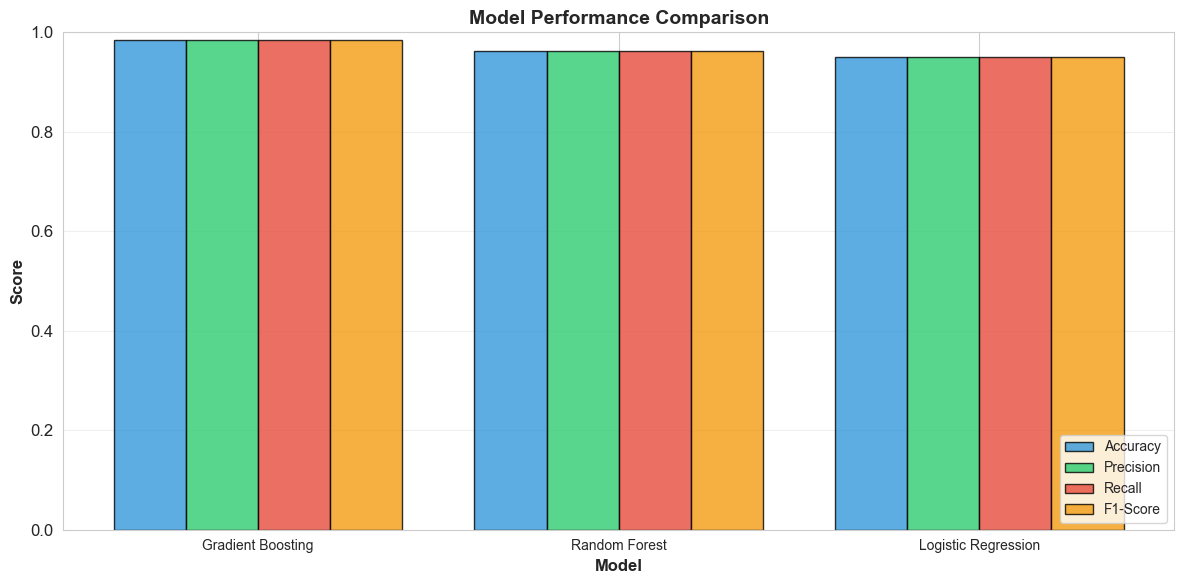

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, comparison_df[metric], width, label=metric, 
           color=colors[i], alpha=0.8, edgecolor='black')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Model'], fontsize=10)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step8_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


✓ Best Model: Gradient Boosting
✓ Accuracy: 0.9843


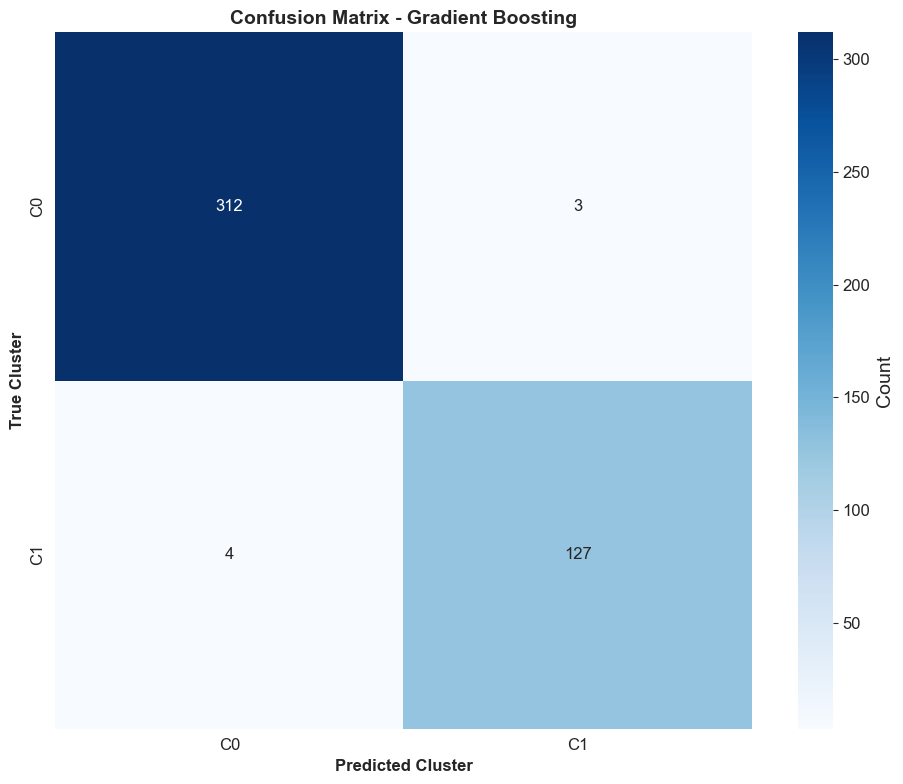

In [17]:
best_model_name = comparison_df.iloc[0]['Model']
best_model, best_predictions = models[best_model_name]

print(f"\n✓ Best Model: {best_model_name}")
print(f"✓ Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=[f'C{i}' for i in range(n_clusters)],
            yticklabels=[f'C{i}' for i in range(n_clusters)],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('True Cluster', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step8_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
print("\nClassification Report:")
print("-" * 70)
print(classification_report(y_test, best_predictions, 
                          target_names=[f'Cluster {i}' for i in range(n_clusters)]))

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Cluster Accuracy:")
print("-" * 70)
for i, acc in enumerate(class_accuracy):
    print(f"Cluster {i}: {acc:.4f} ({acc*100:.2f}%)")


Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Cluster 0       0.99      0.99      0.99       315
   Cluster 1       0.98      0.97      0.97       131

    accuracy                           0.98       446
   macro avg       0.98      0.98      0.98       446
weighted avg       0.98      0.98      0.98       446


Per-Cluster Accuracy:
----------------------------------------------------------------------
Cluster 0: 0.9905 (99.05%)
Cluster 1: 0.9695 (96.95%)


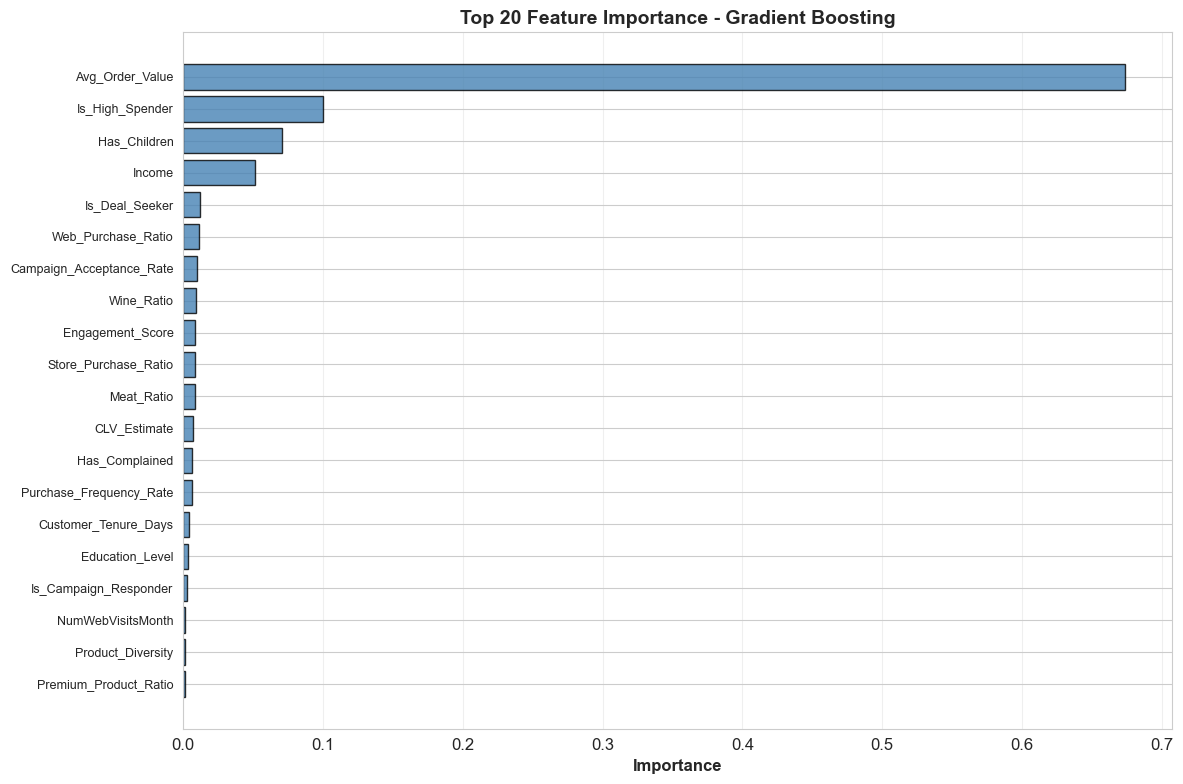

In [19]:
#FEATURE IMPORTANCE VISUALIZATION
if best_model_name == 'Random Forest':
    importance_df = feature_importance_rf
elif best_model_name == 'Gradient Boosting':
    importance_df = feature_importance_gb
else:
    # For Logistic Regression, use coefficient magnitude
    coef_importance = np.abs(lr_model.coef_).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': available_features,
        'Importance': coef_importance
    }).sort_values('Importance', ascending=False)

# Plot top 20 features
top_20_features = importance_df.head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(20), top_20_features['Importance'], color='steelblue', alpha=0.8, edgecolor='black')
plt.yticks(range(20), top_20_features['Feature'], fontsize=9)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title(f'Top 20 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step8_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()



Cross-Validation Results (5-Fold):
----------------------------------------------------------------------
Fold 1: 0.9804
Fold 2: 0.9720
Fold 3: 0.9748
Fold 4: 0.9831
Fold 5: 0.9803

Mean CV Accuracy: 0.9781 (+/- 0.0082)


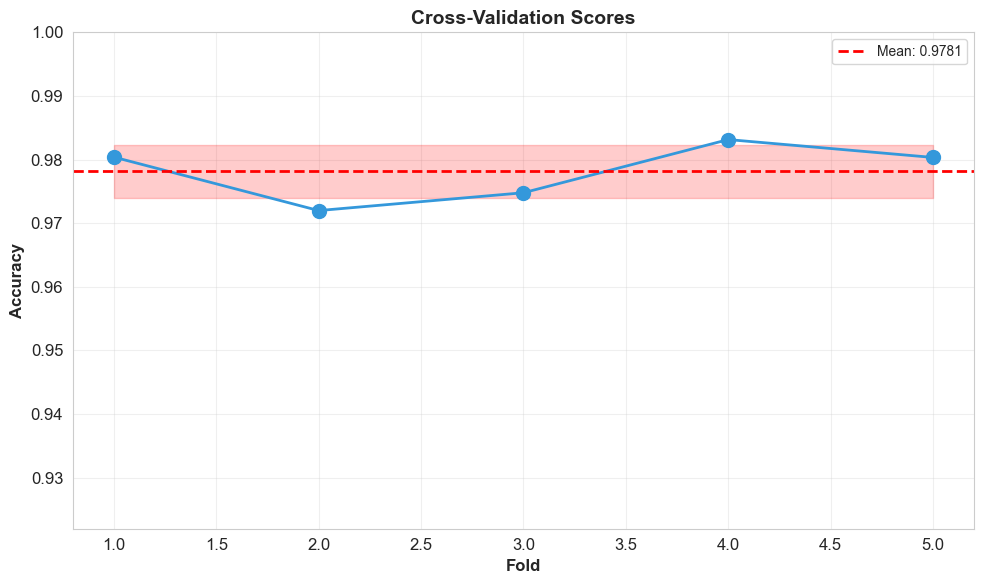

In [20]:
#CROSS-VALIDATION
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

print("\nCross-Validation Results (5-Fold):")
print("-" * 70)
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, 'o-', linewidth=2, markersize=10, color='#3498db')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 6), 
                 cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(),
                 alpha=0.2, color='red')
plt.xlabel('Fold', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([cv_scores.min() - 0.05, 1.0])
plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step8_cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()


Prediction Confidence Distribution:
----------------------------------------------------------------------
High Confidence (≥80%):      442 ( 99.1%)
Medium Confidence (60-80%):    4 (  0.9%)
Low Confidence (<60%):         0 (  0.0%)


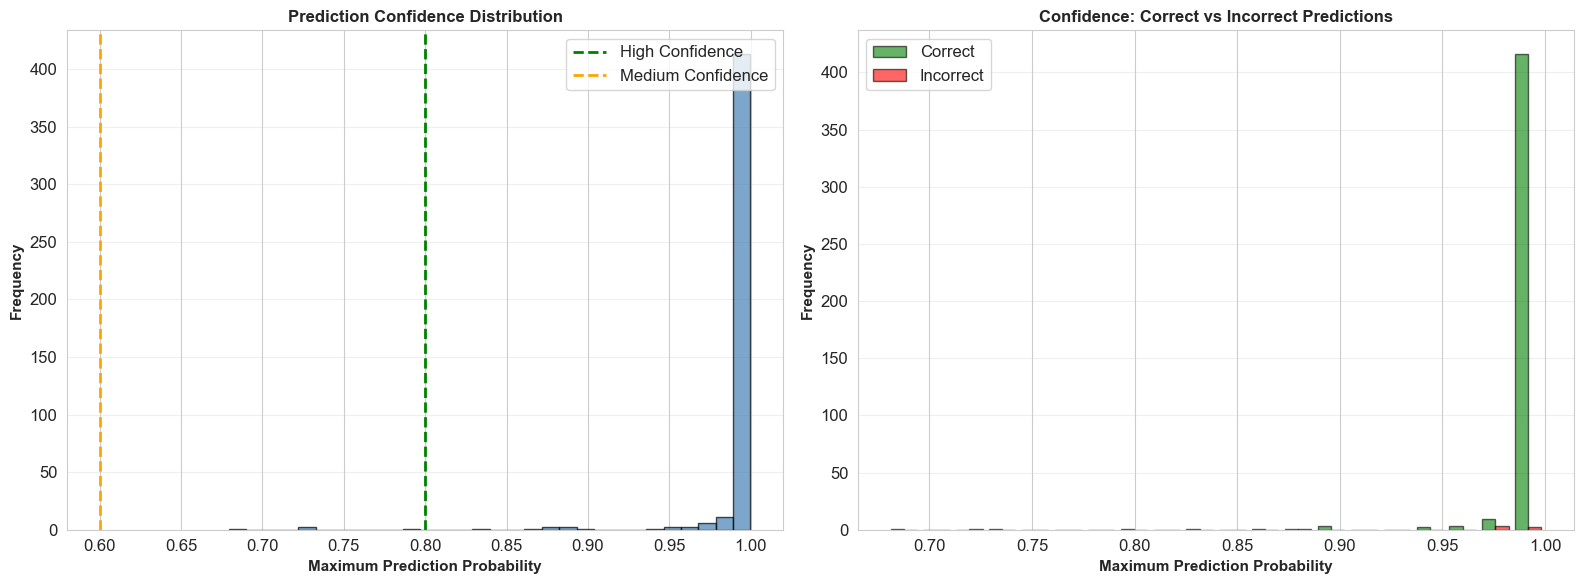

In [21]:
# PREDICTION PROBABILITY DISTRIBUTION
y_pred_proba = best_model.predict_proba(X_test)
max_proba = y_pred_proba.max(axis=1)

# Analyze confidence
high_confidence = (max_proba >= 0.8).sum()
medium_confidence = ((max_proba >= 0.6) & (max_proba < 0.8)).sum()
low_confidence = (max_proba < 0.6).sum()

print("\nPrediction Confidence Distribution:")
print("-" * 70)
print(f"High Confidence (≥80%):     {high_confidence:4d} ({high_confidence/len(y_test)*100:5.1f}%)")
print(f"Medium Confidence (60-80%): {medium_confidence:4d} ({medium_confidence/len(y_test)*100:5.1f}%)")
print(f"Low Confidence (<60%):      {low_confidence:4d} ({low_confidence/len(y_test)*100:5.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of max probabilities
axes[0].hist(max_proba, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.8, color='green', linestyle='--', linewidth=2, label='High Confidence')
axes[0].axvline(x=0.6, color='orange', linestyle='--', linewidth=2, label='Medium Confidence')
axes[0].set_xlabel('Maximum Prediction Probability', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Confidence by correctness
correct_mask = (best_predictions == y_test)
axes[1].hist([max_proba[correct_mask], max_proba[~correct_mask]], 
             bins=20, label=['Correct', 'Incorrect'], 
             color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1].set_xlabel('Maximum Prediction Probability', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Confidence: Correct vs Incorrect Predictions', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step8_prediction_confidence.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# SAVE MODELS AND ARTIFACTS
model_filename = f'D://My projects/customer_segmentation_project/outputs/models/best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✓ Saved best model: {model_filename}")

# Save all models for comparison
with open('D://My projects/customer_segmentation_project/outputs/models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
with open('D://My projects/customer_segmentation_project/outputs/models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('D://My projects/customer_segmentation_project/outputs/models/gradient_boosting.pkl', 'wb') as f:
    pickle.dump(gb_model, f)
print("✓ Saved all trained models")

# Save feature list
feature_config = {
    'features': available_features,
    'n_features': len(available_features),
    'best_model': best_model_name,
    'n_clusters': n_clusters,
    'accuracy': float(comparison_df.iloc[0]['Accuracy'])
}

with open('D://My projects/customer_segmentation_project/outputs/models/model_config.pkl', 'wb') as f:
    pickle.dump(feature_config, f)
print("✓ Saved model configuration")

# Save model comparison report
comparison_df.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step8_model_comparison.csv', index=False)
print("✓ Saved model comparison report")

# Save feature importance
importance_df.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step8_feature_importance.csv', index=False)
print("✓ Saved feature importance")

# Save classification report
with open('D://My projects/customer_segmentation_project/outputs/reports/step8_classification_report.txt', 'w') as f:
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write("=" * 70 + "\n")
    f.write(classification_report(y_test, best_predictions, 
                                  target_names=[f'Cluster {i}' for i in range(n_clusters)]))
print("✓ Saved classification report")

# Save test predictions for analysis
test_results = pd.DataFrame({
    'True_Cluster': y_test,
    'Predicted_Cluster': best_predictions,
    'Max_Probability': max_proba,
    'Correct': correct_mask
})

for i in range(n_clusters):
    test_results[f'Prob_Cluster_{i}'] = y_pred_proba[:, i]

test_results.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step8_test_predictions.csv', index=False)
print("✓ Saved test predictions")


✓ Saved best model: D://My projects/customer_segmentation_project/outputs/models/best_model_gradient_boosting.pkl
✓ Saved all trained models
✓ Saved model configuration
✓ Saved model comparison report
✓ Saved feature importance
✓ Saved classification report
✓ Saved test predictions
